In [1]:
import MDAnalysis as mda 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sn 
import math
import pandas as pd 
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import rdf
from matplotlib import rc
rc('font', **{'serif':['Helvetica']})
rc('text', usetex=True)
import scipy
from scipy.optimize import curve_fit
import math
from MDAnalysis.analysis import polymer

In [2]:
u_eq = mda.Universe("data.psf","dump.equilibration_atom_1","dump.equilibration_atom_2",
                    "dump.equilibration_atom_3","dump.equilibration_atom_4",
                    "dump.equilibration_atom_5",format = 'LAMMPSDUMP')

u_pro = mda.Universe("data.psf","dump.production.atom",format = 'LAMMPSDUMP')

u_total = mda.Universe("data.psf","dump.equilibration_atom_1","dump.equilibration_atom_2",
                       "dump.equilibration_atom_3","dump.equilibration_atom_4","dump.equilibration_atom_5",
                       "dump.production.atom",format = 'LAMMPSDUMP')

C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\coordinates\base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [3]:
print("equilibration no of frames  :  ",len(u_eq.trajectory))
print("production no of frames  :  ",len(u_pro.trajectory))

equilibration no of frames  :   50005
production no of frames  :   50001


In [4]:
def block(vector):
    n = len(vector)
    n_prime = math.ceil(int(n/2))
    x_prime = np.zeros(n_prime)
    for i in range(0,n_prime):
        x_prime[i] = 0.5*(vector[2*i] + vector[2*i+1])
    return x_prime,n_prime

def BlockAv(temp_vec):
    n_prime = math.ceil(int(len(temp_vec)/2))
    count = []
    var_test = []
    sig_test = []
    Av = np.mean(temp_vec)
    i=0
    while n_prime>2:
        t_vec,n_prime = block(temp_vec)
        var_test.append(np.var(t_vec)/(n_prime-1))
        sig_test.append(np.std(t_vec)/np.sqrt(n_prime-1))
        temp_vec = t_vec
        i = i+1
        count.append(i)
    plt.plot(count,sig_test,'o')
    plt.ylabel('std-deviation')
    plt.xticks(np.arange(1,count[-1]+1,2))
    plt.xlabel('block operation No.')
    return Av,sig_test[-2]
    #plt.savefig('block.png',dpi = 600)

In [5]:
#Function for the Minimum Image Convention
def MIC(d):
    global box
    if d > box/2.:
        d = d-box
    elif d < -box/2.:
        d = d + box
    return d

In [6]:
def cluster_search(j):
    global dist,pos,cluster_status,cluster_index,cluster_nr,d_cut,monomer
    for i in range(0,len(pos)):
        if (i != j) & (abs(dist[i,j]) < d_cut) & (cluster_status[i] == 0):
            cluster_status[i] = 1
            cluster_index.append(cluster_nr)
            cluster_search(i)
            

# Key to the algorithm:

## **cluster_nr** : 
### Number of chains. The final value of the **cluster_nr** for each frame is the number of individual clusters. An individual particle is also called a cluster for simplicity. For example at $t=0$, the number of clusters is the total number of particles itself.

## **cluster_status[i]** : 
### It is just a number to indicate whether the cluster status of the $i^{th}$ partcile has been checked or not. 0indicated not checked and 1 indicated checked. At the end of the cluster search, all the particles should have a cluster_status of 1.

## **cluster_index** : 
### Its a vector that stores the cluster identity of the particle. For example, if 
    cluster_index = [0,0,0,0,1,1,1,1,1,2,2,3,4,4,4] 
### then it means that the 4 particles belong to the first cluster, 5particle belong to the 2 cluster, 2 particles belong to the third cluster, 1 particle belongs to the fourth cluster,3 particles belong to the fifth cluster and so on... The length of this vector is equal to the number of particles and the max(cluster_index)+1 gives the total number of clusters for that time frame.

## **particle_in_cluster** : 
### This vector gives the number of particles that are present in each cluster. For example
    particle_in_cluster = [16,8,3,2,1,7,1] 
### means there are 7 clusters in increasing order of their size and their respective sizes are given by the each element in the vector. A size =1 means that it is an individual particle.

## **number_cluster** : 
### This vector gives us an idea about the distribution of the cluster sizes. For example
    number_cluster = [10,3,5,0,6,1] 
### means that there are 10 clusters of size 1, 3clusters of size 2, 5 clusters of size 3, 0 clusters of size 4, 6 clusters of size 5 and 1 cluster of size 6 and so on...In detail, the $i^{th}$ element of the cluster gives the number of clusters of size/length $i$

## number_of_chains :
### This is just to store the number of clusters/chains at each time frame. This is just to see hot the total number of clusters evolve with time.

## monomer_number :
### This stores the number of free monomers at each time frame. This is to see the kinetics of the consumption of monomers and fit it with a rate eqaution and get a rate constant.




# Some data to get from lammps input file:

In [7]:

box = 29.6 #check data.packed
tot_pos = u_total.select_atoms('name B')
eq_pos = u_eq.select_atoms('name B')
pro_pos = u_pro.select_atoms('name B')
pos1 = tot_pos.positions
eq_Avg_chain_size = []
pro_Avg_chain_size = []
eq_number_of_chains = []
pro_number_of_chains = []
eq_time = []
pro_time = []
eq_max_cluster = []
pro_max_cluster = []
eq_frame_dt = 100000  #check input.lmp
pro_frame_dt = 100 #check input.lmp
dt = 0.0002 #check input.lmp
eq_monomer_number = []
pro_monomer_number = []
d_cut = 1.04
dist = np.zeros_like(np.arange(256*256).reshape(len(pos1),len(pos1)),dtype = float)    

In [8]:
#Equilibrium Analysis:
for ts in u_eq.trajectory[0:-1:100]:
    eq_time.append(ts.time*eq_frame_dt*dt)
    pos = eq_pos.positions # this stores the positions of the particles in [Nx3] matrix/array
    for i in range(0,len(pos)):
        for j in range(0,len(pos)):
            if i != j:
                dx = MIC(pos[i,0] - pos[j,0])
                dy = MIC(pos[i,1] - pos[j,1])
                dz = MIC(pos[i,2] - pos[j,2])
                dist[i,j] = math.sqrt(dx*dx + dy*dy + dz*dz)
            if i == j:
                dist[i,j] = 0
    cluster_nr = 0
    
    cluster_status = np.zeros_like(np.arange(len(pos)))
    cluster_index=[]
    for i in range(0,len(pos)):
        if cluster_status[i] == 0:
            cluster_status[i] = 1
            cluster_search(i)
            cluster_index.append(cluster_nr)
            cluster_nr = cluster_nr + 1 
    
    particle_in_cluster = np.zeros_like(np.arange(cluster_nr))

    for i in range(0,len(pos)):
        particle_in_cluster[cluster_index[i]] = particle_in_cluster[cluster_index[i]] + 1
    start_size = 1
    end_size = np.max(particle_in_cluster)
    number_cluster = []
    for i in range(start_size,end_size+1):
        number_cluster.append(particle_in_cluster.tolist().count(i))
    eq_number_of_chains.append(cluster_nr)
    eq_monomer_number.append(number_cluster[0])
    eq_max_cluster.append(len(particle_in_cluster)) 
    num = []
    for k in range(0,len(number_cluster)):
        num.append(k+1)
    eq_Avg_chain_size.append(np.average(num,weights=number_cluster))

In [ ]:
type(dist)
Min = []
for i in range(0,len(dist)):
    for j in range(0,len(dist)):
        if (abs(dist[i,j]) <= 1.1) & (dist[i,j] > 0.):
            Min.append(abs(dist[i,j]))
            #print(i,j) # will print pairs of particles
plt.plot(Min)
print(len(Min))
print(np.mean(Min),np.std(Min))

In [9]:
#Production Analysis
for ts in u_pro.trajectory[0:-1:100]:
    pro_time.append(ts.time*pro_frame_dt*dt)
    pos = pro_pos.positions # this stores the positions of the particles in [Nx3] matrix/array
    for i in range(0,len(pos)):
        for j in range(0,len(pos)):
            if i != j:
                dx = MIC(pos[i,0] - pos[j,0])
                dy = MIC(pos[i,1] - pos[j,1])
                dz = MIC(pos[i,2] - pos[j,2])
                dist[i,j] = math.sqrt(dx*dx + dy*dy + dz*dz)
            if i == j:
                dist[i,j] = 0
    cluster_nr = 0
    
    cluster_status = np.zeros_like(np.arange(len(pos)))
    cluster_index=[]
    for i in range(0,len(pos)):
        if cluster_status[i] == 0:
            cluster_status[i] = 1
            cluster_search(i)
            cluster_index.append(cluster_nr)
            cluster_nr = cluster_nr + 1
        
    particle_in_cluster = np.zeros_like(np.arange(cluster_nr))

    for i in range(0,len(pos)):
        particle_in_cluster[cluster_index[i]] = particle_in_cluster[cluster_index[i]] + 1
    start_size = 1
    end_size = np.max(particle_in_cluster)
    number_cluster = []
    for i in range(start_size,end_size+1):
        number_cluster.append(particle_in_cluster.tolist().count(i))
    pro_number_of_chains.append(cluster_nr)
    pro_monomer_number.append(number_cluster[0])
    pro_max_cluster.append(len(particle_in_cluster))  
    num = []
    for k in range(0,len(number_cluster)):
        num.append(k+1)
    pro_Avg_chain_size.append(np.average(num,weights=number_cluster))

In [10]:
pro_time = [eq_time[-1]+x for x in pro_time]
total_time = np.concatenate((eq_time,pro_time))
total_monomer_number = np.concatenate((eq_monomer_number,pro_monomer_number))

C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


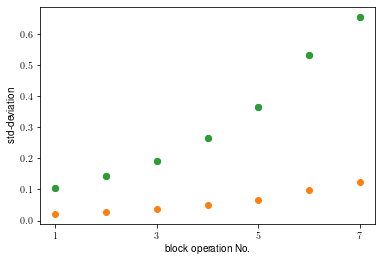

In [11]:
av_l,s_l = BlockAv(pro_number_of_chains)
av,s = BlockAv(pro_Avg_chain_size)
max_av,max_s = BlockAv(pro_max_cluster)

In [12]:
#writing the information to a file
print("average number of clusters (production) : ",av_l, " +- ",s_l)
print(number_cluster)
print(np.sum(particle_in_cluster)) #- to check whether all particles are accounte for
print("weighted average chain length (production): ", av , " +- ", s)
print("The production average maximum cluster size :",max_av," +- ",max_s)

average number of clusters (production) :  37.066  +-  0.654402782162548
[7, 5, 6, 1, 4, 2, 1, 2, 0, 2, 2, 3, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
256
weighted average chain length (production):  6.921452549555426  +-  0.12424293960535789
The production average maximum cluster size : 37.066  +-  0.654402782162548


In [13]:
#writing xhain size distribution to a file:
fileh = open("analysis_files/chain_size_distribution.dat","w")
fileh.write("Cluster Size Distribution:\n")
fileh.write("Num of particles    Number of clusters\n")
num = []
for i in range(0,len(number_cluster)):
    fileh.write("%d              %d\n"%(i+1,number_cluster[i]))
    num.append(i+1)
fileh.close()

In [18]:
print(particle_in_cluster)

[27 13 14  6 17  5  8  5 13  8 10 12 12  3 11  4 12  3 10  2  2  2  1 11
  3  6  2  1  1  7  5  3  3  5  1  1  3  2  1  1]


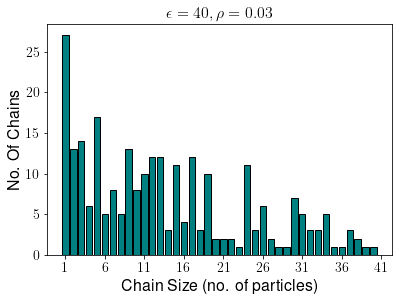

In [25]:
fig = plt.figure()
ax = fig.add_axes([0.15,0.15,0.80,0.80])
ax.bar(np.arange(1,41),particle_in_cluster,color = 'green',edgecolor = 'black')
plt.xlabel("Chain Size (no. of particles)", fontsize = 16)
plt.ylabel("No. Of Chains",fontsize = 16)
plt.title(r"$ \epsilon = 40,\rho = 0.03 $",fontsize = 16)
plt.xticks(np.arange(1,44,4),fontsize =14)
plt.yticks(fontsize = 14)
plt.savefig("figures/chain_size_barplot.png",dpi = 600)


In [ ]:
# writing chain statistics to a file:
stat_f = open('analysis_files/chain_stats.dat','w')
print("average number of chains (production)",file = stat_f)
print(av_l, " +- ",s_l,"\n",file = stat_f)
print("weighted average chain length (production):",file = stat_f)
print(av , " +- ", s,"\n",file = stat_f)
print("production average maximum chain size:",file = stat_f)
print(max_av," +- ",max_s,"\n",file = stat_f)
stat_f.close()

# Monomer concentration wrt time
The monomer concentration is fitted to a PBE correspondin to A Brownian Coagualation model devised by Soluchowski (Taken from *Smoke, Dust and Haze by Sheldon Freidlander*). The monomer fraction is given by:
$$ m = \frac{1}{(1+kt)^2}$$


In [ ]:
def objective_fun(x,k):
    m0 = 1.0
    return m0/(1+k*x)**2

X = eq_time
Y = np.array(eq_monomer_number)/256
pars, cov = curve_fit(f=objective_fun, xdata=X, ydata=Y, p0=[0])
print(pars)
y = objective_fun(total_time,pars)

[1.35303326e-05]


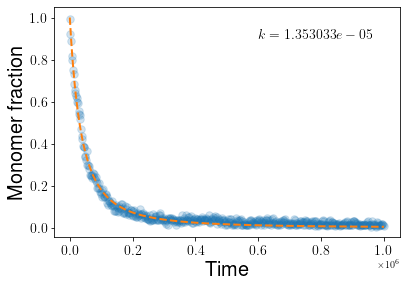

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.15,0.15,0.80,0.80])
ax.plot(eq_time,Y,'.',markersize = 15,alpha = 0.2)
ax.plot(total_time,y,'--',linewidth = 2)
#plt.text(0.7e6,200,"$\frac{m_0}{(1+kt)^2}$",fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time',fontsize = 20)
plt.ylabel("Monomer fraction",fontsize = 20)
plt.text(0.6e6, 0.9, '$k=%e$'%(pars), fontsize=14)
plt.savefig("figures/monomer_rate.png",dpi = 600)
r_f = open("analysis_files/rate.dat",'w')
print("monomer depletion rate:",file = r_f)
print(pars[0],file = r_f)
r_f.close()

C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\coordinates\base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\analysis\rdf.py:417: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\analysis\rdf.py:425: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


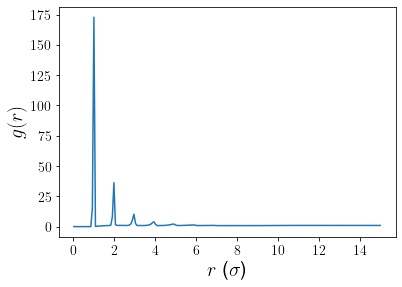

In [31]:
#calculating and plotting radial distribution function (g(r))
B_select = u_pro.select_atoms('name B')
irdf = rdf.InterRDF(B_select,B_select,exclusion_block=(1,1),nbins=200)
irdf.run()
fig = plt.figure()
ax = fig.add_axes([0.15,0.15,0.78,0.8])
ax.plot(irdf.bins, irdf.rdf)
plt.xlabel('$r$ ($\sigma$)',fontsize = 20)
plt.ylabel('$g(r)$',fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig("figures/rdf.png",dpi = 600)

1.7781862251926996


C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\analysis\rdf.py:417: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\MDAnalysis\analysis\rdf.py:425: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


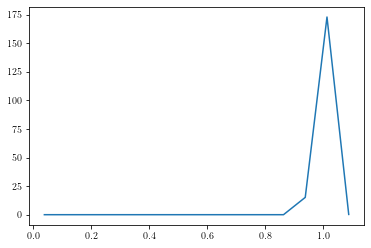

In [32]:
# Calculating coordination number from radial distribution function
rdf_r = irdf.bins;
rdf_g = irdf.rdf;
plt.plot(rdf_r[:15],rdf_g[:15])
CN = 0
number_density = 256/(box**3) #check equilibration.dat
mass_density = 0.03 #check equilibration.dat
for i in range(0,16):
    CN = CN + (4*3.14*number_density*rdf_g[i]*(rdf_r[i]**2))*(rdf_r[i+1]-rdf_r[i])
print(CN)  

In [33]:
# calculating coordination number from average number of nearest neighbours
def contacts_within_cutoff(u, group_a, group_b, radius=1.1):
    timeseries = []
    for ts in u.trajectory:
        # calculate distances between group_a and group_b
        d = contacts.distance_array(group_a.positions, group_b.positions)
        # determine which distances <= radius
        n_contacts = contacts.contact_matrix(d, radius).sum()
        timeseries.append([ts.frame, n_contacts])
    return np.array(timeseries)

coordination number from average neighbour:
1.4022769598040197 +- 0.16292350916764395
coordination number from g(r):
1.7781862251926996


C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\envs\mdanalysis\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


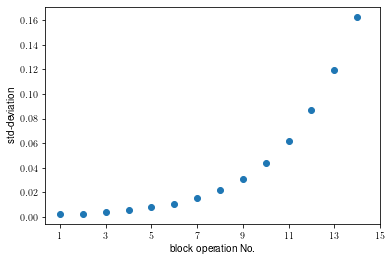

In [34]:
ca = contacts_within_cutoff(u_eq,u_eq.select_atoms('name B'),u_eq.select_atoms('name B'), radius=1.04)
neigh = (ca[:,1]-256)/256
av_neigh,sig_neigh = BlockAv(neigh)
print("coordination number from average neighbour:")
print(av_neigh, "+-", sig_neigh)
print("coordination number from g(r):")
print(CN)
f = open('analysis_files/coordination.dat','w')
print("coordination number from average neighbour:",file = f)
print(av_neigh, "+-", sig_neigh,"\n",file = f)
print("coordination number from g(r):",file = f)
print(CN,file =f)
f.close()

# Vector Plot

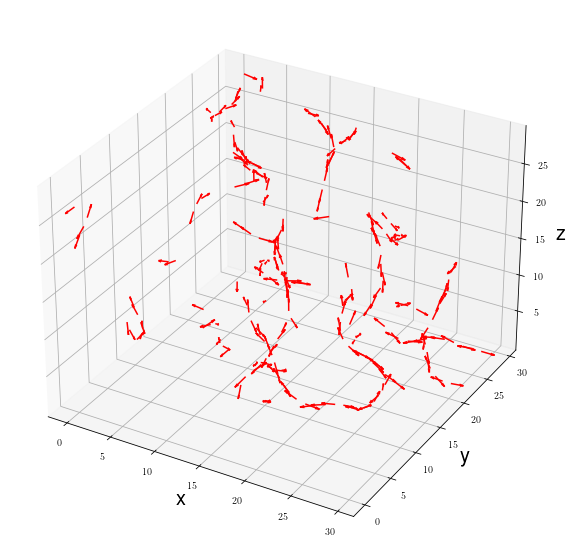

In [51]:
A = u_pro.select_atoms('name A')
B = u_pro.select_atoms('name B')
A1 = u_pro.atoms[list(range(0,768,3))]
for ts in u_pro.trajectory[-1]:
    posB = B.positions
    posA = A1.positions
ax = plt.figure(figsize = (10,10)).add_subplot(projection='3d')
x = posB[:,0]
y = posB[:,1]
z = posB[:,2]
u = posB[:,0]-posA[:,0]
v = posB[:,1]-posA[:,1]
w = posB[:,2]-posA[:,2]

ax.quiver(x,y,z,u,v,w,normalize=True,color = "red",length = 1.5)
ax.set_xlabel("x",fontsize = 20)
ax.set_ylabel("y",fontsize=20)
ax.set_zlabel("z",fontsize = 20)
plt.savefig("figures/quiver.png",dpi = 600)


# Chain Orientation Factor:

In [ ]:
def cluster_search_new(j):
    global dist,pos,cluster_status,cluster_index,cluster_nr,d_cut,monomer
    for i in range(0,len(pos)):
        if (i != j) & (abs(dist[i,j]) < d_cut) & (cluster_status[i] == 0):
            cluster_status[i] = 1
            cluster_index.append(cluster_nr)
            cluster_search(i)           

In [60]:
B = u_pro.select_atoms('name B')
A1 = u_pro.atoms[list(range(0,768,3))]
A2 = u_pro.atoms[list(range(0,768,3))]
for ts in u_pro.trajectory[-1]:
    posB = B.positions
    posA1 = A1.positions
    posA2 = A2.positions
print(posA1[1])
print(posA1[1,0])
print(posA1[1,1])
print(posA1[1,2])


[18.216171  20.117018   2.8156137]
18.216171
20.117018
2.8156137
